# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [2]:
! pip install wordcloud

     ------------------------------------ 152.1/152.1 kB 477.6 kB/s eta 0:00:00


In [4]:
!pip install emoji

     ------------------------------------ 358.9/358.9 kB 189.2 kB/s eta 0:00:00


In [6]:
!pip install spacy

     -------------------------------------- 12.0/12.0 MB 130.2 kB/s eta 0:00:00
     ------------------------------------ 122.2/122.2 kB 179.2 kB/s eta 0:00:00
     -------------------------------------- 45.9/45.9 kB 285.0 kB/s eta 0:00:00
     -------------------------------------- 48.9/48.9 kB 309.0 kB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 162.0 kB/s eta 0:00:00
     ------------------------------------- 181.6/181.6 kB 89.9 kB/s eta 0:00:00
     ------------------------------------ 481.6/481.6 kB 151.6 kB/s eta 0:00:00
     ------------------------------------ 374.5/374.5 kB 295.2 kB/s eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 240.6 kB/s eta 0:00:00
  Using cached typing_extensions-4.7.1-py3-none-any.whl (33 kB)
     ---------------------------------------- 7.4/7.4 MB 245.7 kB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.4.0
    Uninstalling typing_extensions-4.

In [1]:
import math

import numpy as np
import pandas as pd
import re
import os, sys
import emoji
import time

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from wordcloud import WordCloud

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.dummy import DummyClassifier

import nltk
import spacy
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from lightgbm import LGBMClassifier

import torch
import transformers

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply
#tqdm shows the progress bar, number of iterations, time taken to run the loop, and frequency of iterations per second.
tqdm.pandas()

## Load Data

In [6]:
#df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'}, encoding='latin-1')
df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'}, encoding='latin-1')

In [7]:
# shape
df_reviews.shape

(47331, 17)

In [8]:
# top 5
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [9]:
# info
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [10]:
# missing values
#df_reviews.isnull().sum()
null_values = df_reviews.isnull().sum()
print(null_values)

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64


In [11]:
# duplicates
df_reviews.duplicated().sum()

0

In [12]:
# target
df_reviews['pos'].value_counts(normalize=True)

0    0.501046
1    0.498954
Name: pos, dtype: float64

In [13]:
# 5 point summary
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,47329.0,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,25562.917323,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,83670.039163,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.0,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,827.0,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3197.0,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,13974.0,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1739448.0,10.000000,1.000000,12499.000000


**Conclusion**

1) There are 47331 reviews

2) Only 2 reviews are missing an `average_rating` and `votes`.

3) There are no duplicates based on `idx`

4) The target `pos` appears balanced, that is, there are an equal number of positive and negative reviews.

5) The oldest review was for a movie released in 1894, and the most recent review is in 2010.

6) The mean rating for a category is ~6.

7) The number of votes range from as few as 9 votes to 1.7 Million votes.

8) The individual rating ranges from 1 to 10.

## EDA

Let's check the number of movies and reviews over years.

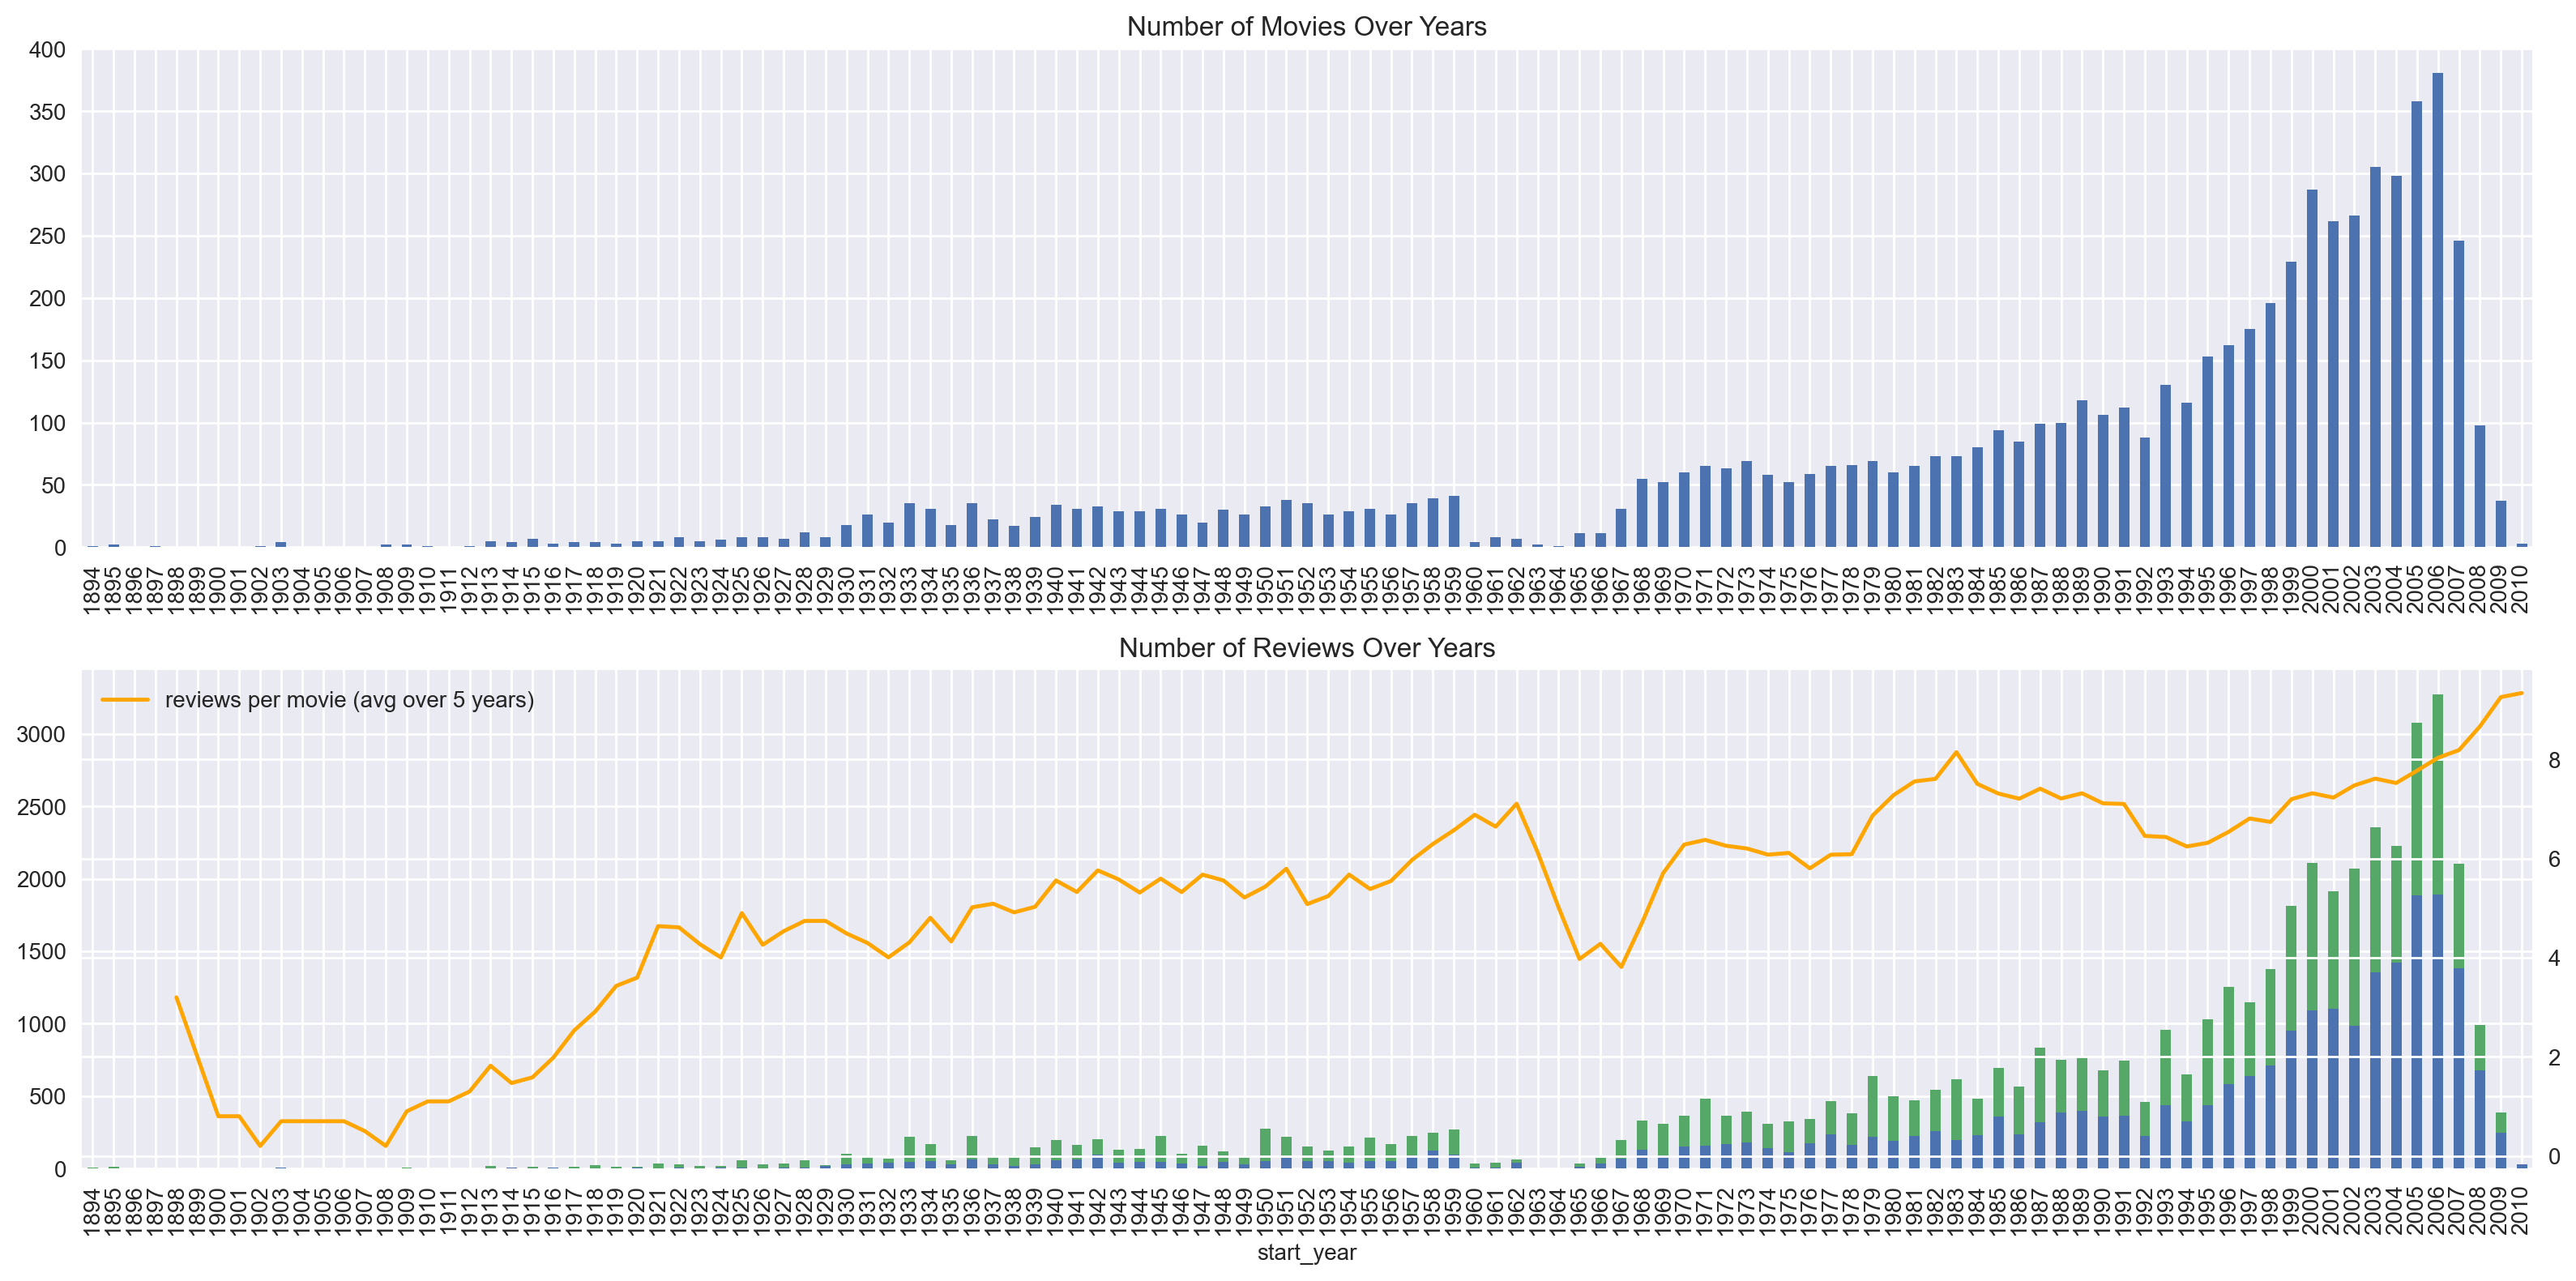

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), dft1.index.max()+1)).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), dft2.index.max()+1)).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), dft2.index.max()+1)).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

1) Most moviews during this dataset was created came out in 2006. At least 3000 movies.

Let's check the distribution of number of reviews per movie with the exact counting and KDE (Kernel density estimation)

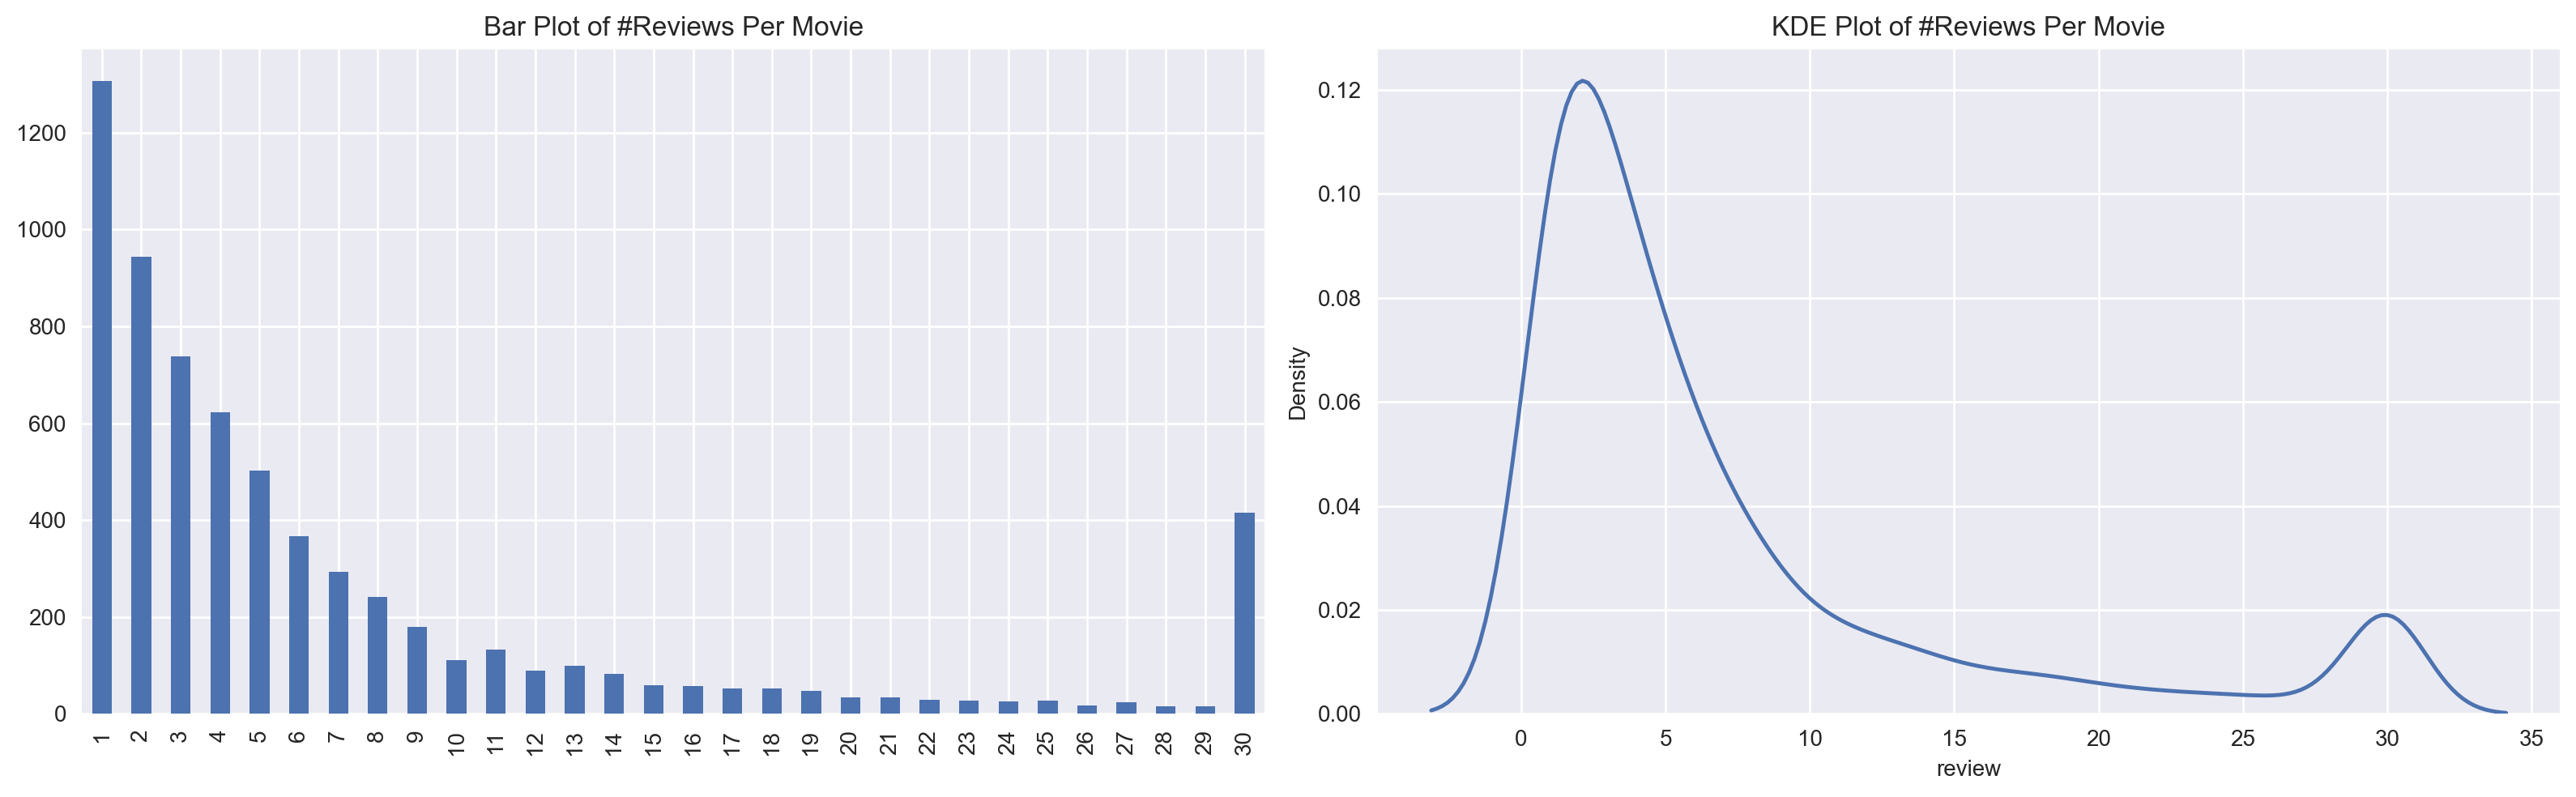

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

1) Most movies have received a single review. Around 400 of them have received 30 reviews.

In [16]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

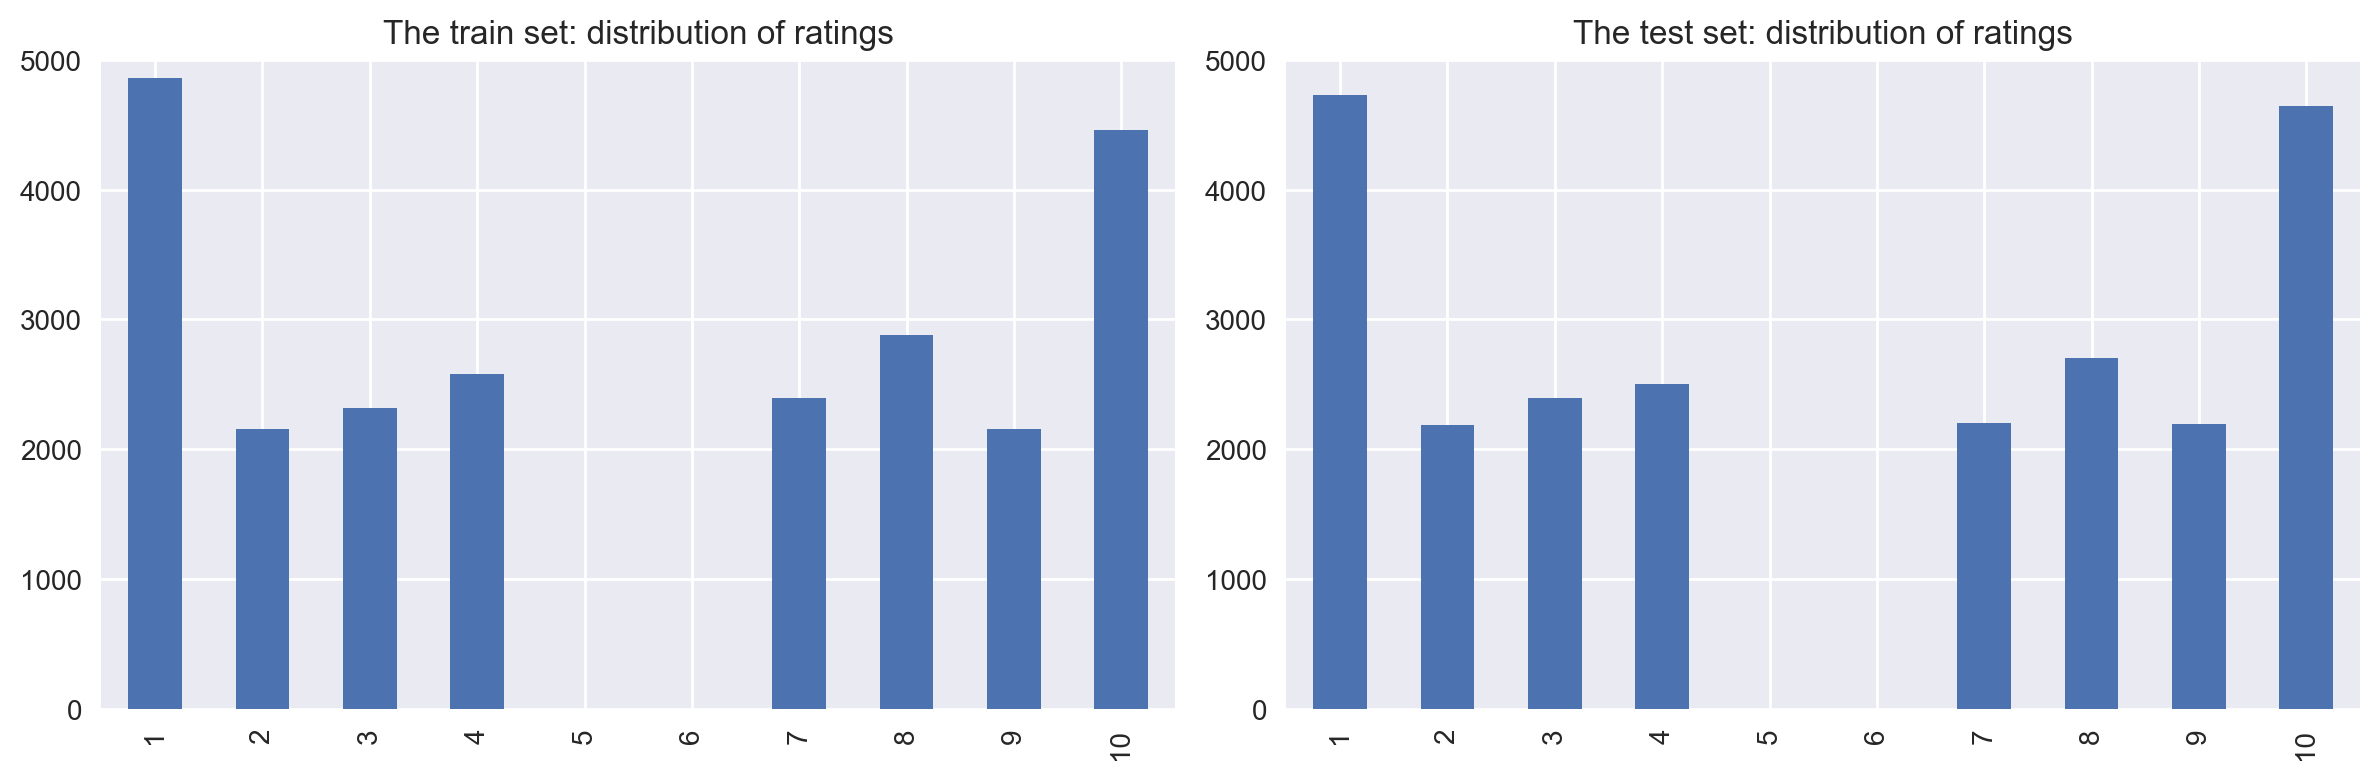

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

1) The distribution in ratings between the train and test sets look similar, with gaps for rating 5 and 6.

Distribution of negative and positive reviews over the years for two parts of the dataset

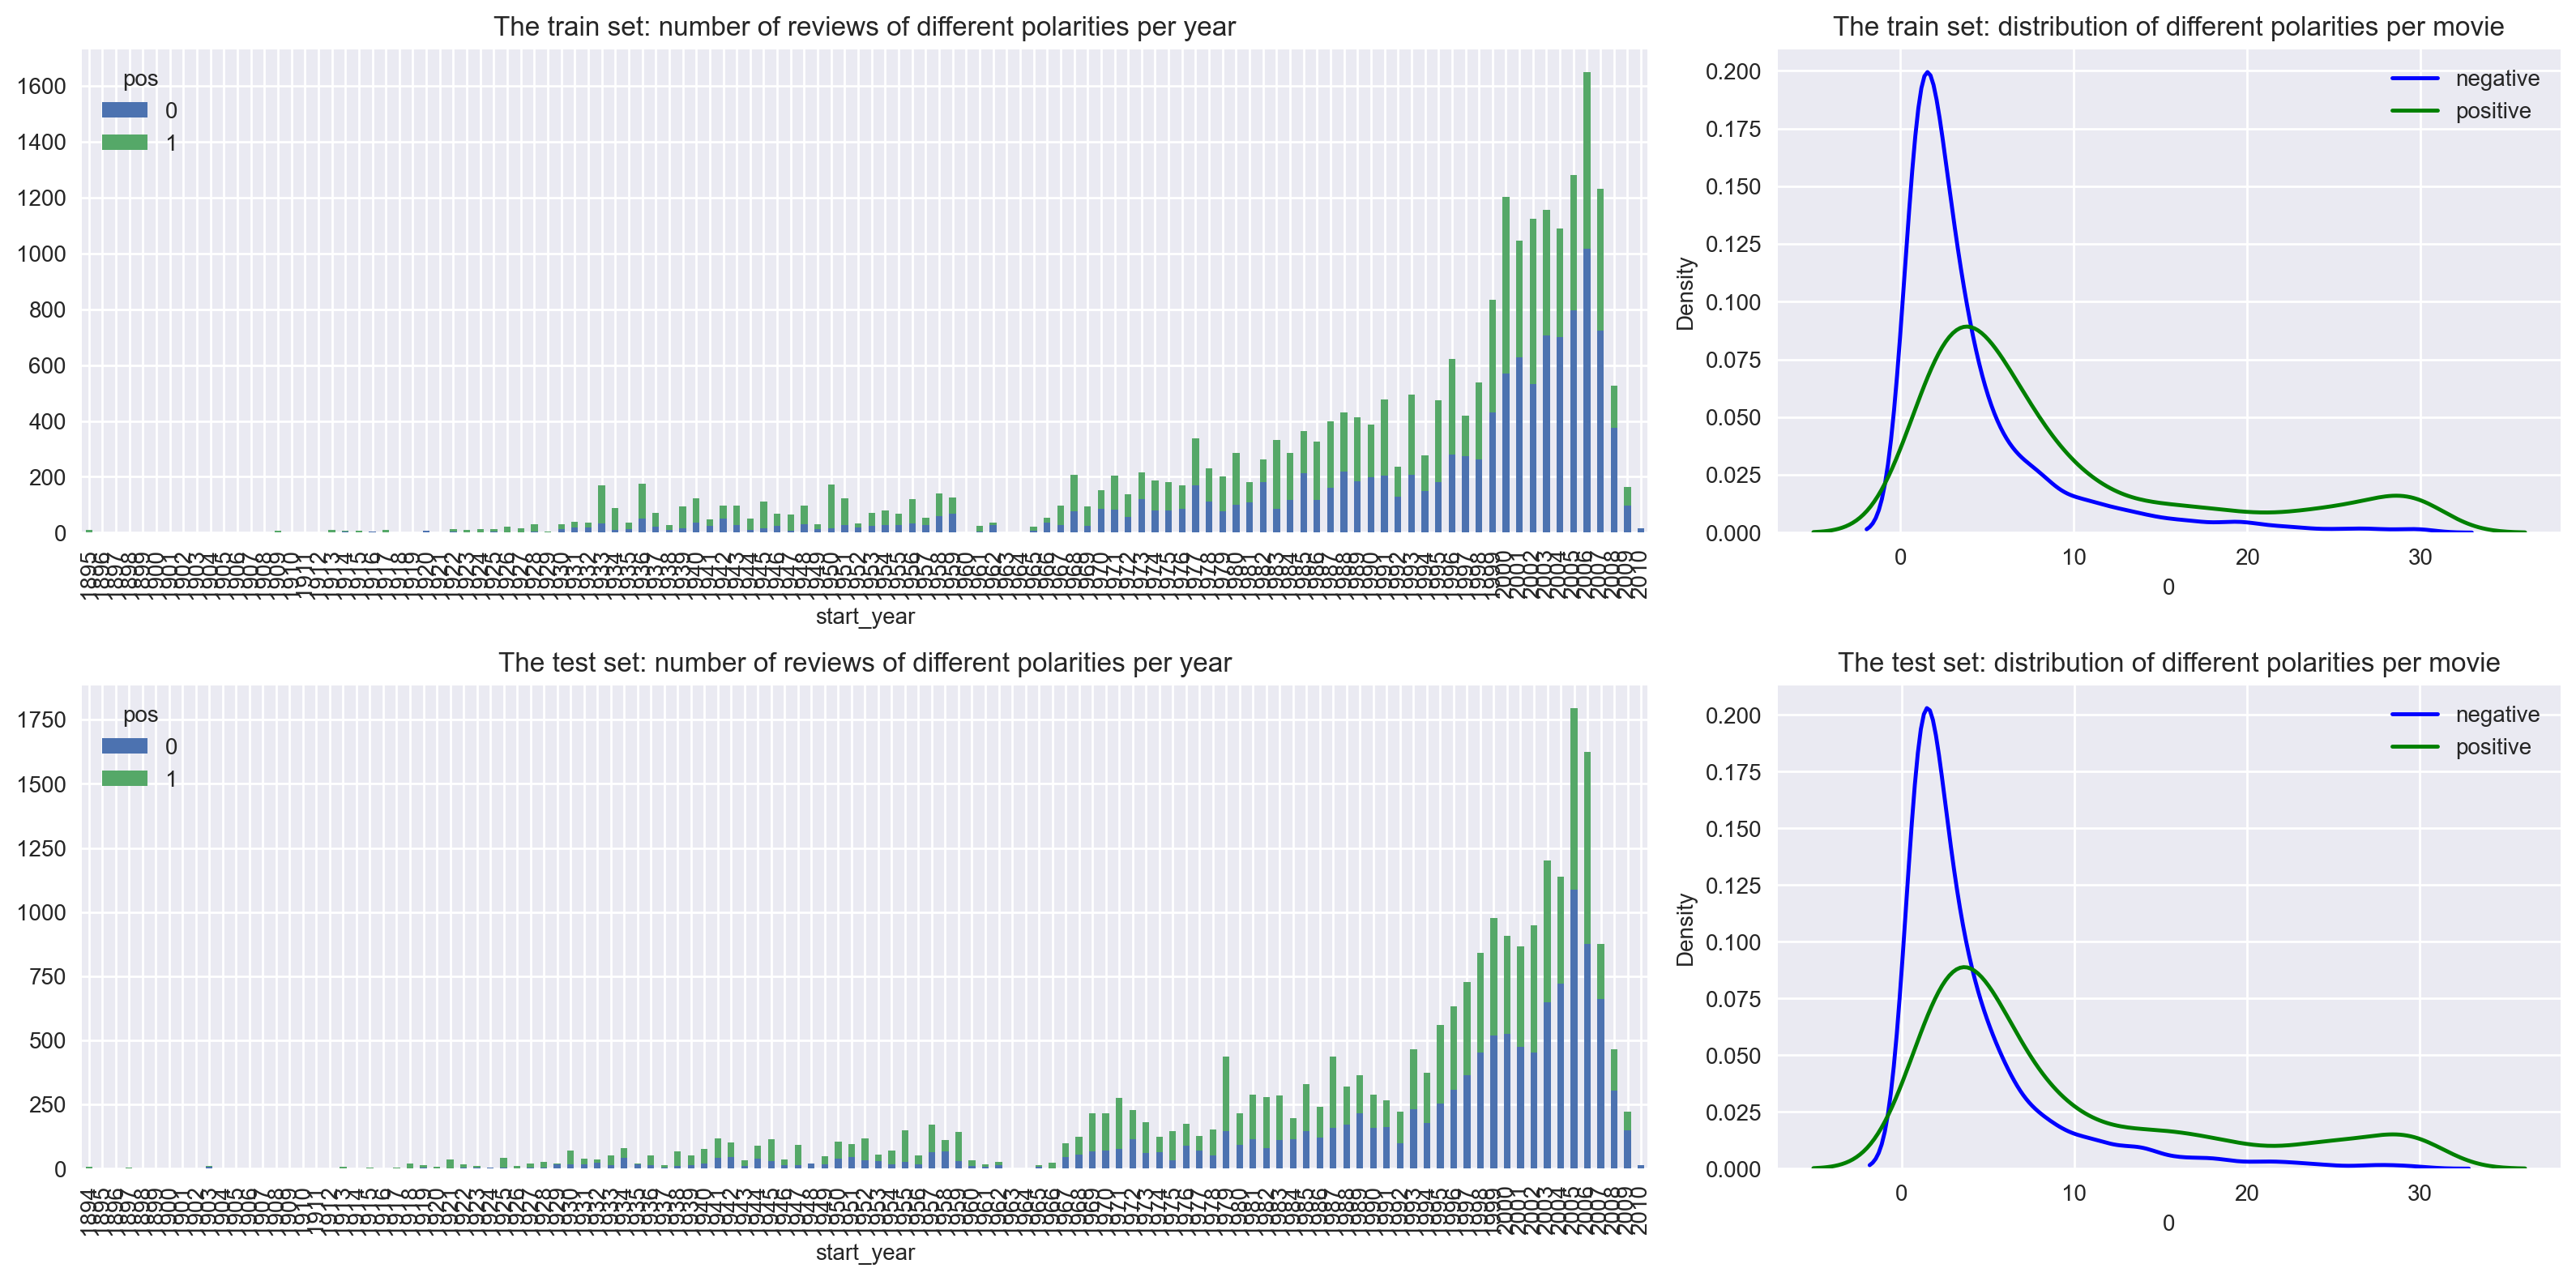

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), dft.index.max()+1)).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), dft.index.max()+1)).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

1) The distribution in polarities of reviews between the train and test set look similar.

Word cloud of positive reviews

In [19]:
def create_word_cloud(df, target, val=1, is_filter=True, title=None):
    """
    Cerate word cloud of positive and negative reviews
    """
    text = ''
    '+*[a-z]+'
    if is_filter:
        pat = re.compile(r'movie|film|saw|really|watched|first|one|time|s|even')
        text = " ".join(re.sub(pat, '', review) for review in df[df[target] == val]['review'])
    else:
        text = " ".join(review for review in df[df[target] == val]['review'])
    wc = WordCloud(collocations=False, background_color='white').generate(text)
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")
    plt.show()

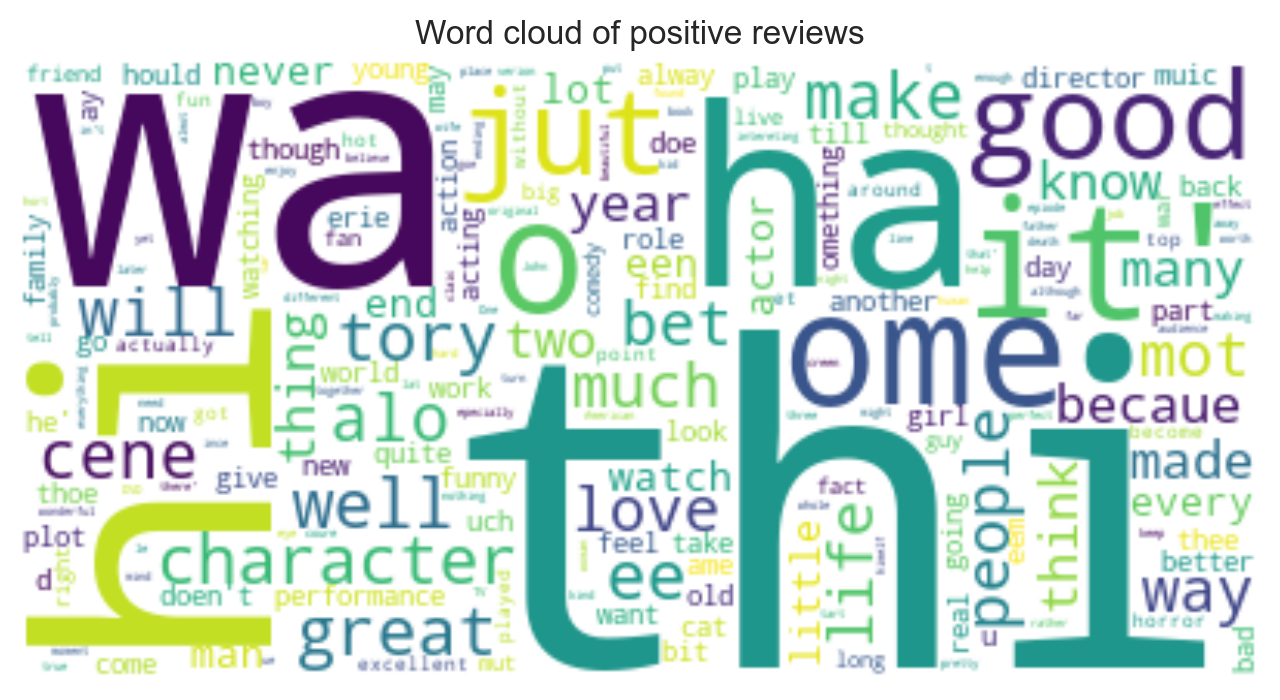

In [20]:
create_word_cloud(df_reviews, 'pos', val=1, is_filter=True, title='Word cloud of positive reviews')

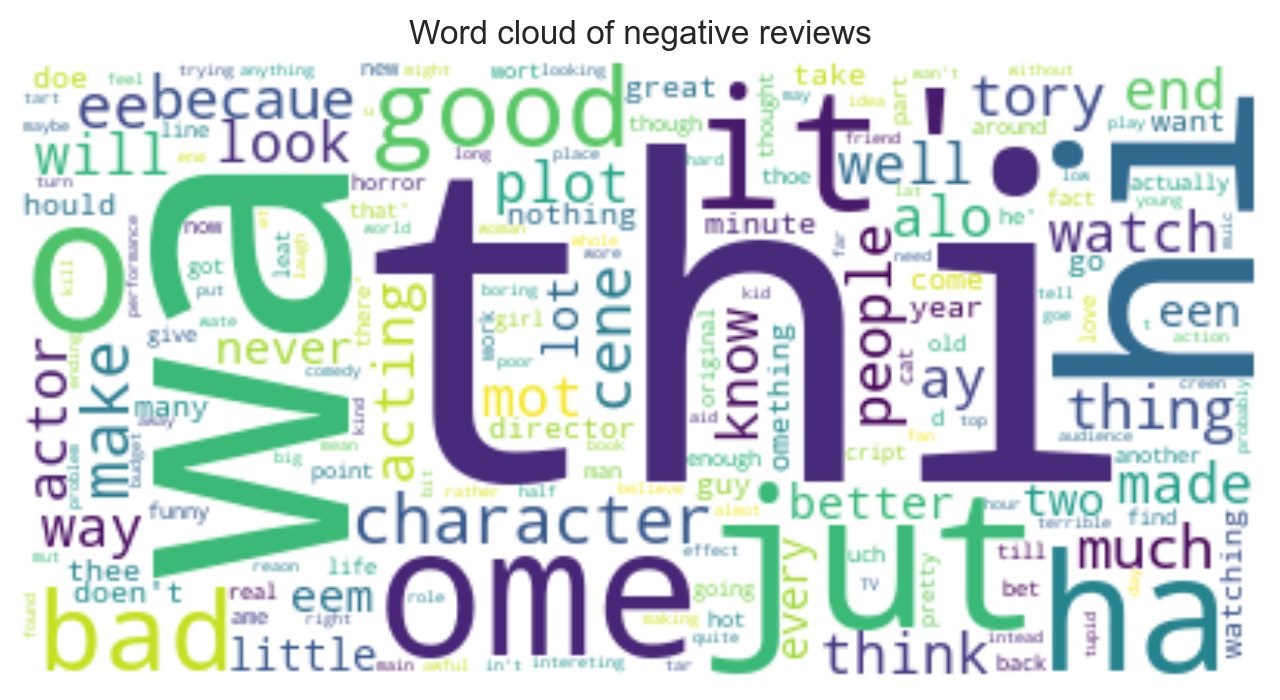

In [21]:
create_word_cloud(df_reviews, 'pos', val=0, is_filter=True, title='Word cloud of negative reviews')

1) The word cloud doesn't really differentiate between good and bad reviews.

**Conclusion**

1) The classes are balanced.

2) Majority of the movies came out in 2006.

3) Most of the movies have a single review. However, 30 movies have about 400 reviews each.

4) The distribution of `ratings` in both the train and test sets are similar.

5) The distribution of polarities of movie reviews during the years are similar.

6) The word cloud of positive and negative reviews doesn't reveal anything interesting.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [22]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [23]:
lemmatizer  = WordNetLemmatizer()

In [24]:
def clean_reviews(text):
    """
    Clean the review

    """
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^a-z\']', ' ', text)
    # text = emoji.get_emoji_regexp().sub(u'', text)
    text = text.encode('ascii', 'ignore').decode('ascii')
    # text = " ".join(lemmatizer.lemmatize(word) for word in word_tokenize(text))
    text = re.sub(r'\s+', ' ', text)
    return text

In [25]:
%%time
df_reviews['reviews_norm'] = df_reviews['review'].apply(clean_reviews)

CPU times: total: 20.5 s
Wall time: 21.8 s


## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [26]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_y = df_reviews_train['pos']
test_y = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Working with models

In [27]:
def build_model(model, train_X, train_y, test_X, test_y, 
                hyperparameters={}, 
                scoring=None, cv=5, model_str=None, cat_features=[], 
                early_stopping_rounds=50, verbose=False):
    """
    Build model
    """
    np.random.seed(42)
    best_score = 0
    start_time = time.time()
    
    if model_str == 'dummy':
        model.fit(train_X, train_y)
        preds = model.predict(train_X)
        best_score = f1_score(train_y, preds)
        return model, best_score, np.round(time.time() - start_time, 2)
    gs = GridSearchCV(model, param_grid=hyperparameters, cv=cv, scoring=scoring)
    gs.fit(train_X, train_y)
    if model_str == 'lgbm':
        gs.best_estimator_.fit(train_X, train_y, verbose=verbose)
    else:
        gs.best_estimator_.fit(train_X, train_y)
    preds = gs.best_estimator_.predict(test_X)
    best_score = f1_score(test_y, preds)
    end_time = time.time() - start_time
    return gs.best_estimator_, best_score, np.round(end_time, 2)

### Model 0 - Constant

In [28]:
dc = DummyClassifier()
best_dc_model, best_dc_f1, best_dc_time = build_model(dc, df_reviews_train['reviews_norm'], train_y, 
                                                        df_reviews_test['reviews_norm'], test_y,
                                                        hyperparameters={'C' : [.01, .1, 1, 10]}, 
                scoring='f1_weighted', cv=2, model_str='dummy')

In [29]:
# test set
best_dc_f1

0.0

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


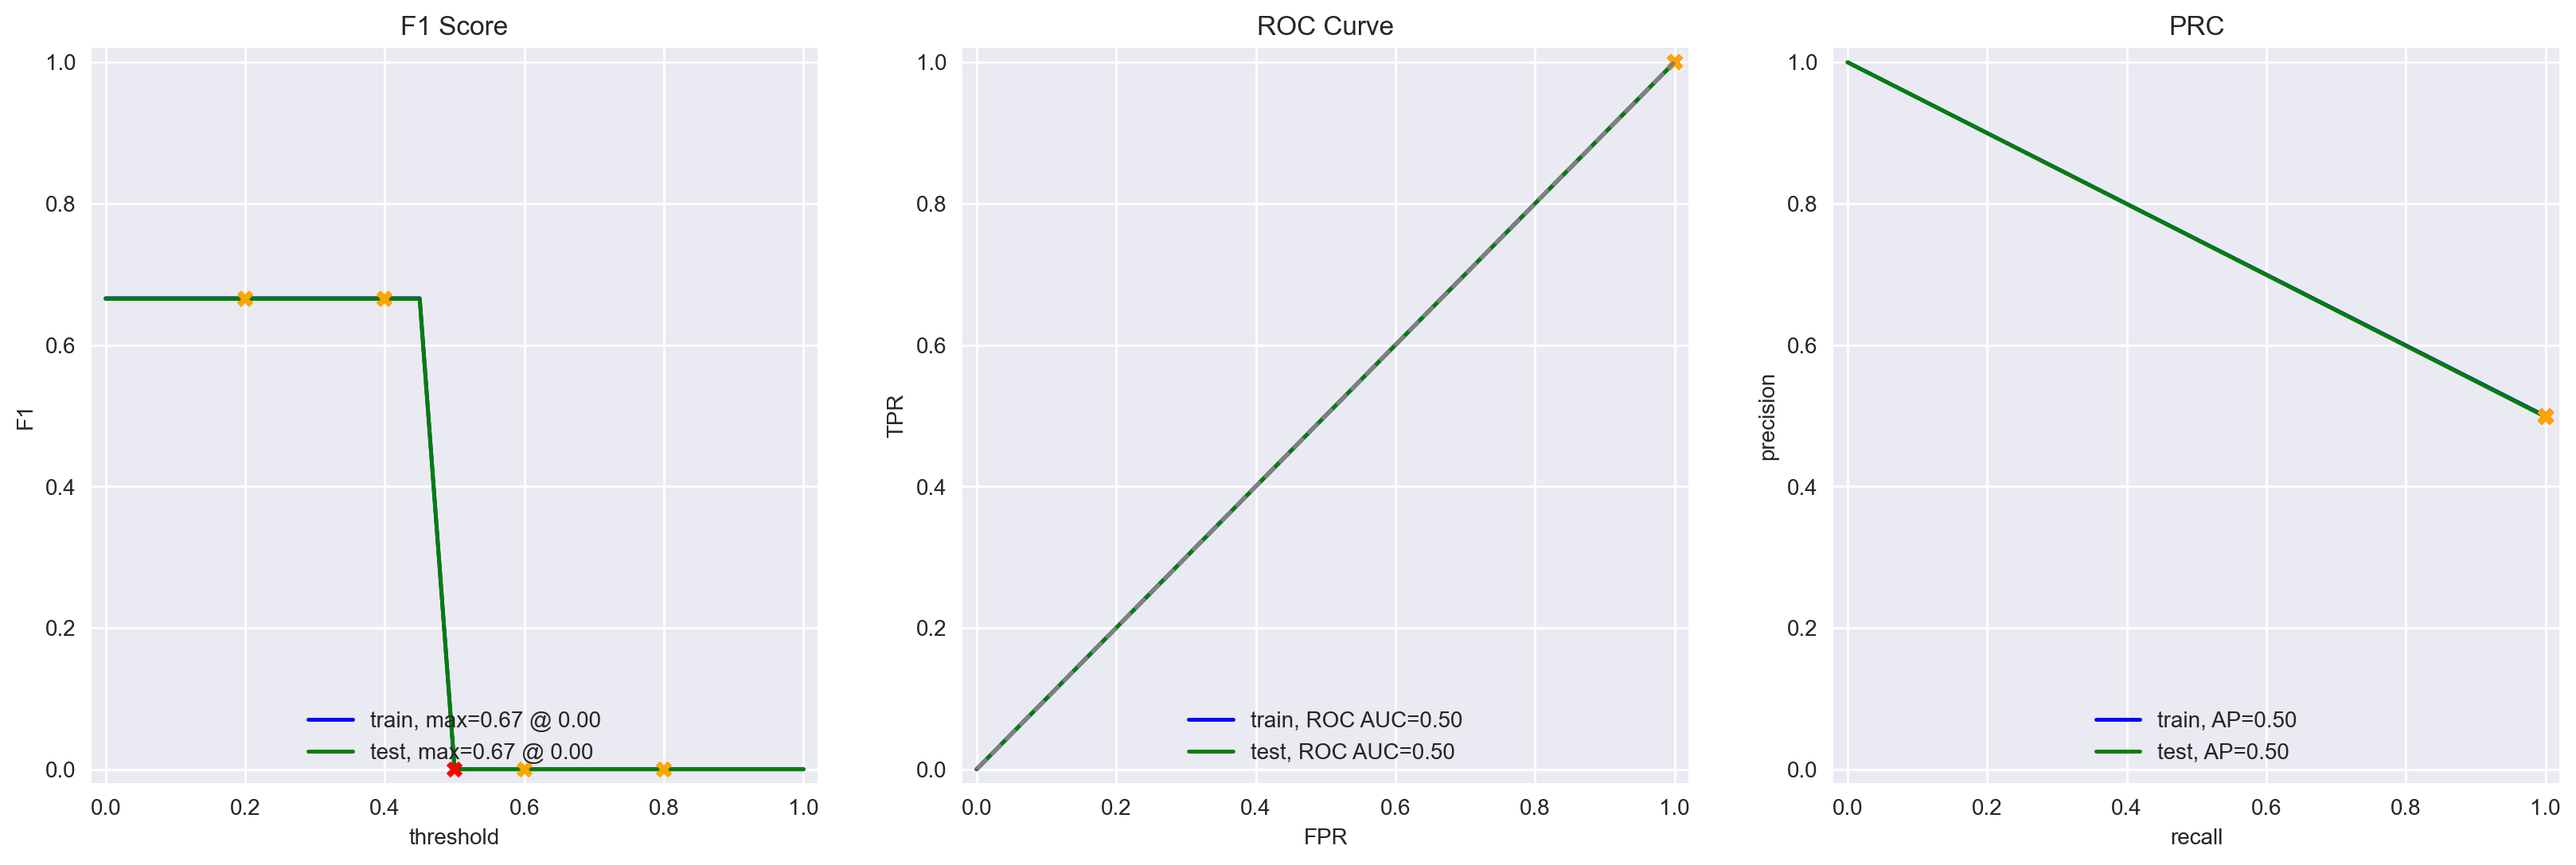

In [30]:
evaluate_model(best_dc_model, df_reviews_train['reviews_norm'], train_y, df_reviews_test['reviews_norm'], test_y)

1) As expected, the dummy classifier performs as good as flipping an unbiased coin.

### NLTK, TF-IDF and LR

TF-IDF

In [31]:
def text_preprocessing_1(text):
    """
    Word tokenize and lemmatize text
    """
    tokens = word_tokenize(text)
    return " ".join(lemmatizer.lemmatize(token) for token in tokens)

In [32]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [33]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [34]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [35]:
%%time
df_reviews_train['reviews_nltk'] = df_reviews_train['reviews_norm'].apply(text_preprocessing_1)
df_reviews_test['reviews_nltk'] = df_reviews_test['reviews_norm'].apply(text_preprocessing_1)

CPU times: total: 3min 11s
Wall time: 3min 21s


In [36]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [41]:
%%time
tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stopwords.words('english'), max_df=0.9, min_df=10)
train_X = tfidf_vectorizer_1.fit_transform(df_reviews_train['reviews_nltk'])
test_X = tfidf_vectorizer_1.transform(df_reviews_test['reviews_nltk'])

CPU times: total: 18.4 s
Wall time: 20.1 s


In [42]:
lr = LogisticRegression()
best_lr_model, best_lr_f1, best_lr_time = build_model(lr, train_X, train_y, 
                                                        test_X, test_y,
                                                        hyperparameters={'C' : [.01, .1, 1, 10]}, 
                scoring='f1_weighted', cv=5)

In [43]:
# test set - using nltk
best_lr_f1

0.8805154903132201

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


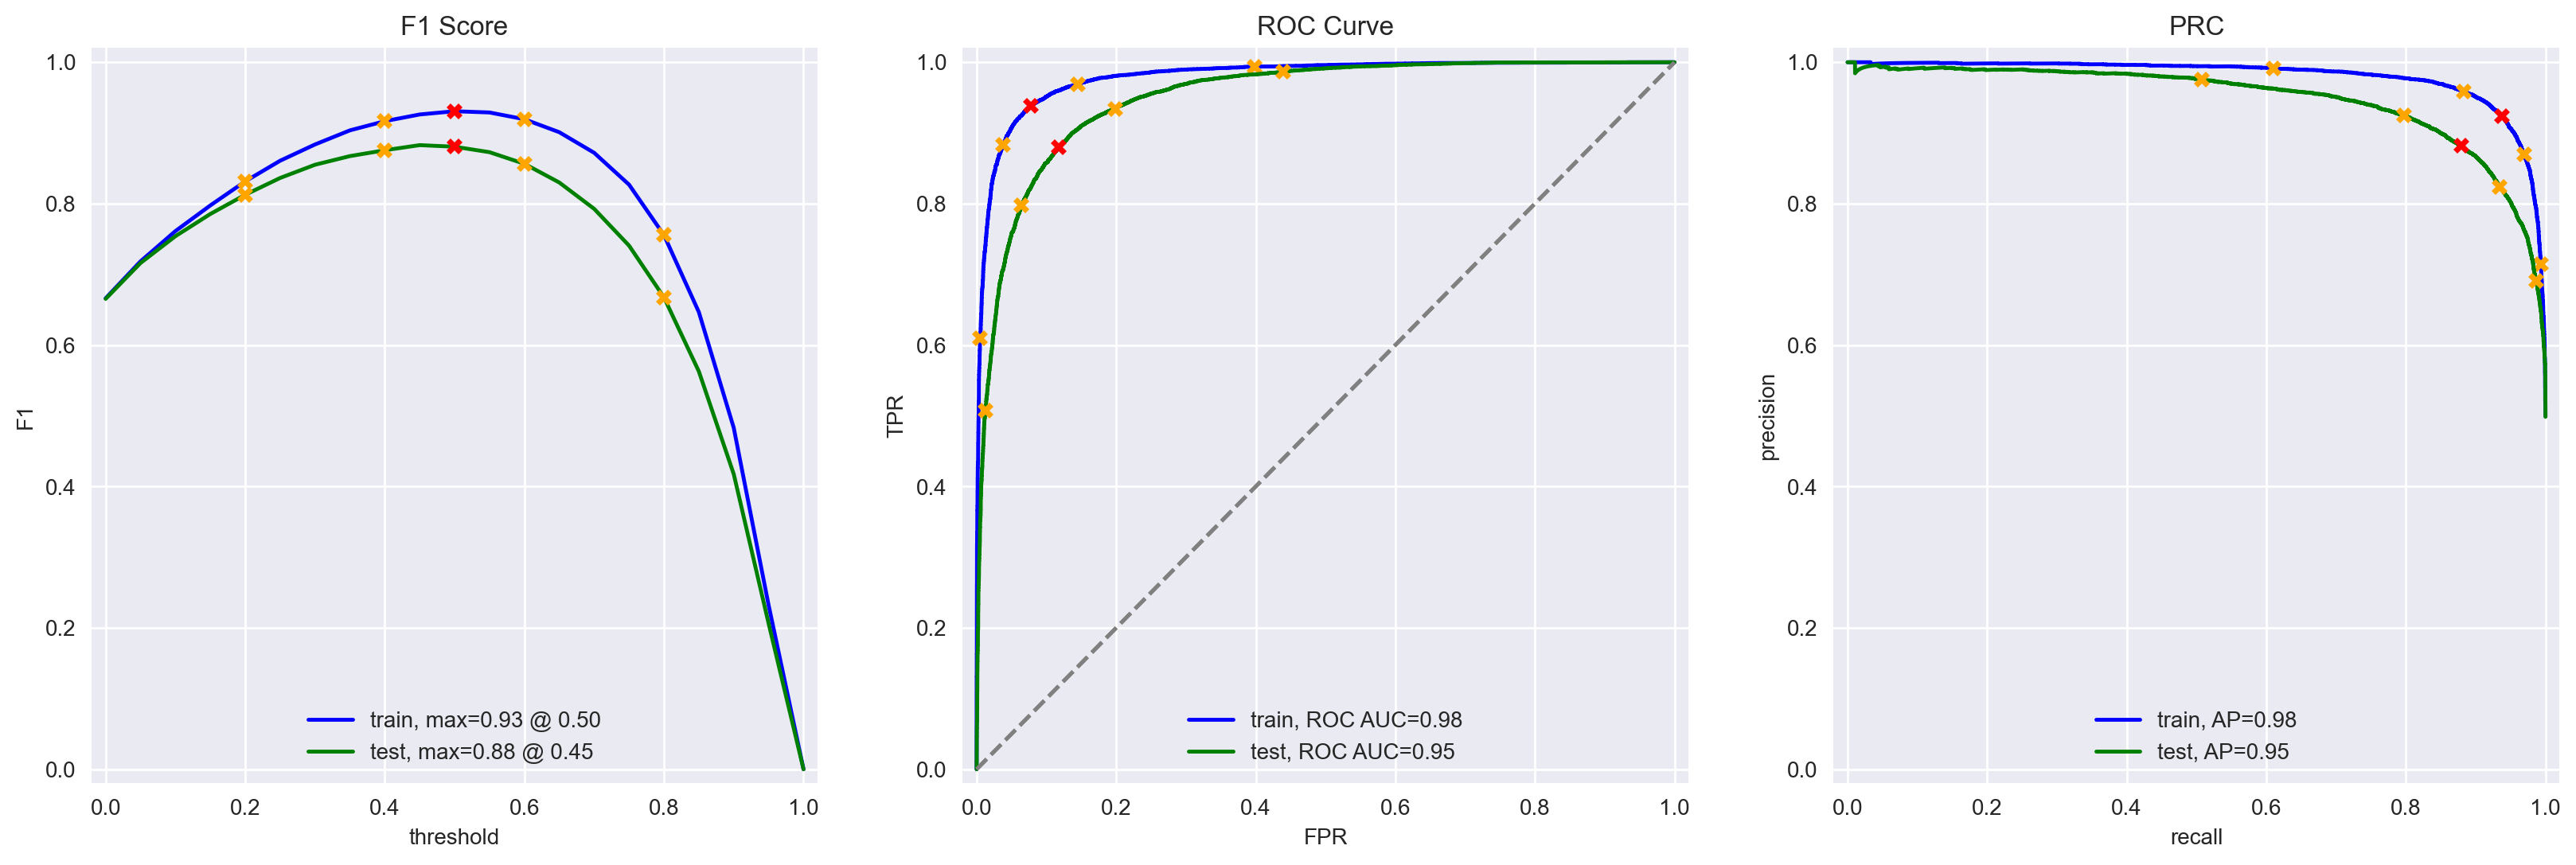

In [40]:
evaluate_model(best_lr_model, train_X, train_y, test_X, test_y)

###  spaCy, TF-IDF and LR

In [52]:
!spacy download en_core_web_sm

     -------------------------------------- 12.8/12.8 MB 632.8 kB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
spacy.load('en_core_web_sm')
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [ ]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [ ]:
%%time
tfidf_vectorizer_3 = TfidfVectorizer(stop_words=stopwords.words('english'), max_df=0.9, min_df=10)
df_reviews_train['reviews_spacy'] = df_reviews_train['reviews_norm'].apply(text_preprocessing_3)
df_reviews_test['reviews_spacy'] = df_reviews_test['reviews_norm'].apply(text_preprocessing_3)

In [ ]:
train_X = tfidf_vectorizer_3.fit_transform(df_reviews_train['reviews_spacy'])
test_X = tfidf_vectorizer_3.transform(df_reviews_test['reviews_spacy'])

In [ ]:
lr = LogisticRegression()
best_lr_spacy_model, best_lr_spacy_f1, best_lr_spacy_time = build_model(lr, train_X, train_y, 
                                                        test_X, test_y,
                                                        hyperparameters={'C' : [.01, .1, 1, 10]}, 
                scoring='f1_weighted', cv=5)

In [ ]:
# test set- using spacy
best_lr_spacy_f1

In [ ]:
evaluate_model(best_lr_spacy_model, train_X, train_y, test_X, test_y)

### spaCy, TF-IDF and LGBMClassifier

In [61]:
lgbm = LGBMClassifier(learning_rate=0.1, boosting_type='gbdt',
                      objective='binary',
                      feature_fraction=0.8,
                      random_state=42)
best_lgbm_model, best_lgbm_f1, best_lgbm_time = build_model(lgbm, train_X, train_y, 
                                                        test_X, test_y,
                                                        hyperparameters={'n_estimators': range(100, 600, 100)}, 
                scoring='f1_weighted', cv=3, model_str='lgbm',
           cat_features=[])

In [62]:
# test set- using spacy
best_lgbm_f1

0.8697759449003017

          train  test
Accuracy   0.99  0.87
F1         0.99  0.87
APS        1.00  0.94
ROC AUC    1.00  0.95


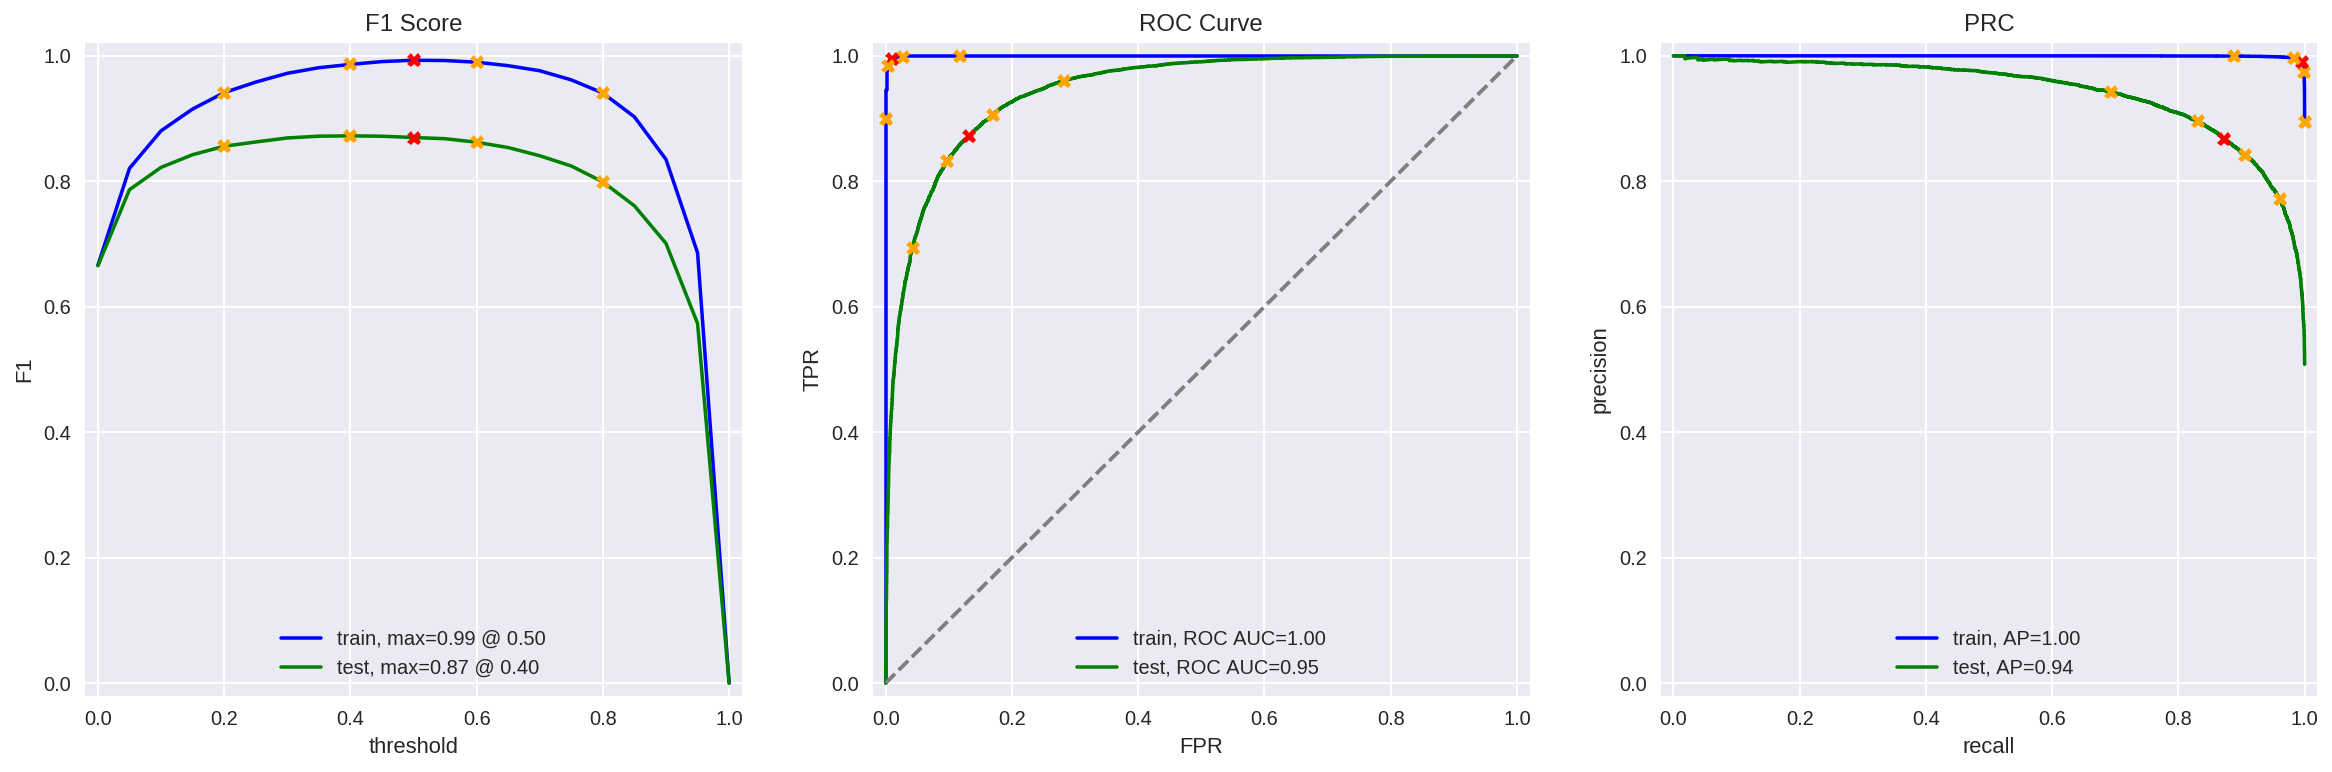

In [63]:
evaluate_model(best_lgbm_model, train_X, train_y, test_X, test_y)

###  BERT

In [100]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [95]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
#     ids_series = texts.apply(lambda x: tokenizer.encode(x.lower(), 
#                                                         add_special_tokens=True, 
#                                                         truncation=True, 
#                                                         max_length=max_length)
#                             )
#     ids_series = ids_series.apply(lambda x: np.array(x + [0]*(max_length - len(x))))
#     attention_mask_series = ids_series.apply(lambda x: np.where(x !=0, 1, 0))
    for input_text in texts:
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [ ]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
# Extract embedding on Colab
# train_features_9 = BERT_text_to_embeddings(df_reviews_train['reviews_norm'], force_device='cuda')

In [ ]:
# if you have got the embeddings, it's advisable to save them to have them ready if 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

In [66]:
with np.load('features_9.npz') as data:
    train_features_9 = data['train_features']
    test_features_9 = data['test_features']

In [67]:
print(df_reviews_train['reviews_norm'].shape)
print(train_features_9.shape)
print(train_y.shape)

(23796,)
(23796, 768)
(23796,)


In [68]:
lr = LogisticRegression()
best_bert_model, best_bert_f1, best_bert_time = build_model(lr, train_features_9, train_y, 
                                                        test_features_9, test_y,
                                                        hyperparameters={'C' : [.01, .1, 1, 10]}, 
                scoring='f1_weighted', cv=5)

In [69]:
# test set- using bert
best_bert_f1

0.8644417684500258

          train  test
Accuracy   0.87  0.87
F1         0.87  0.86
APS        0.94  0.94
ROC AUC    0.94  0.94


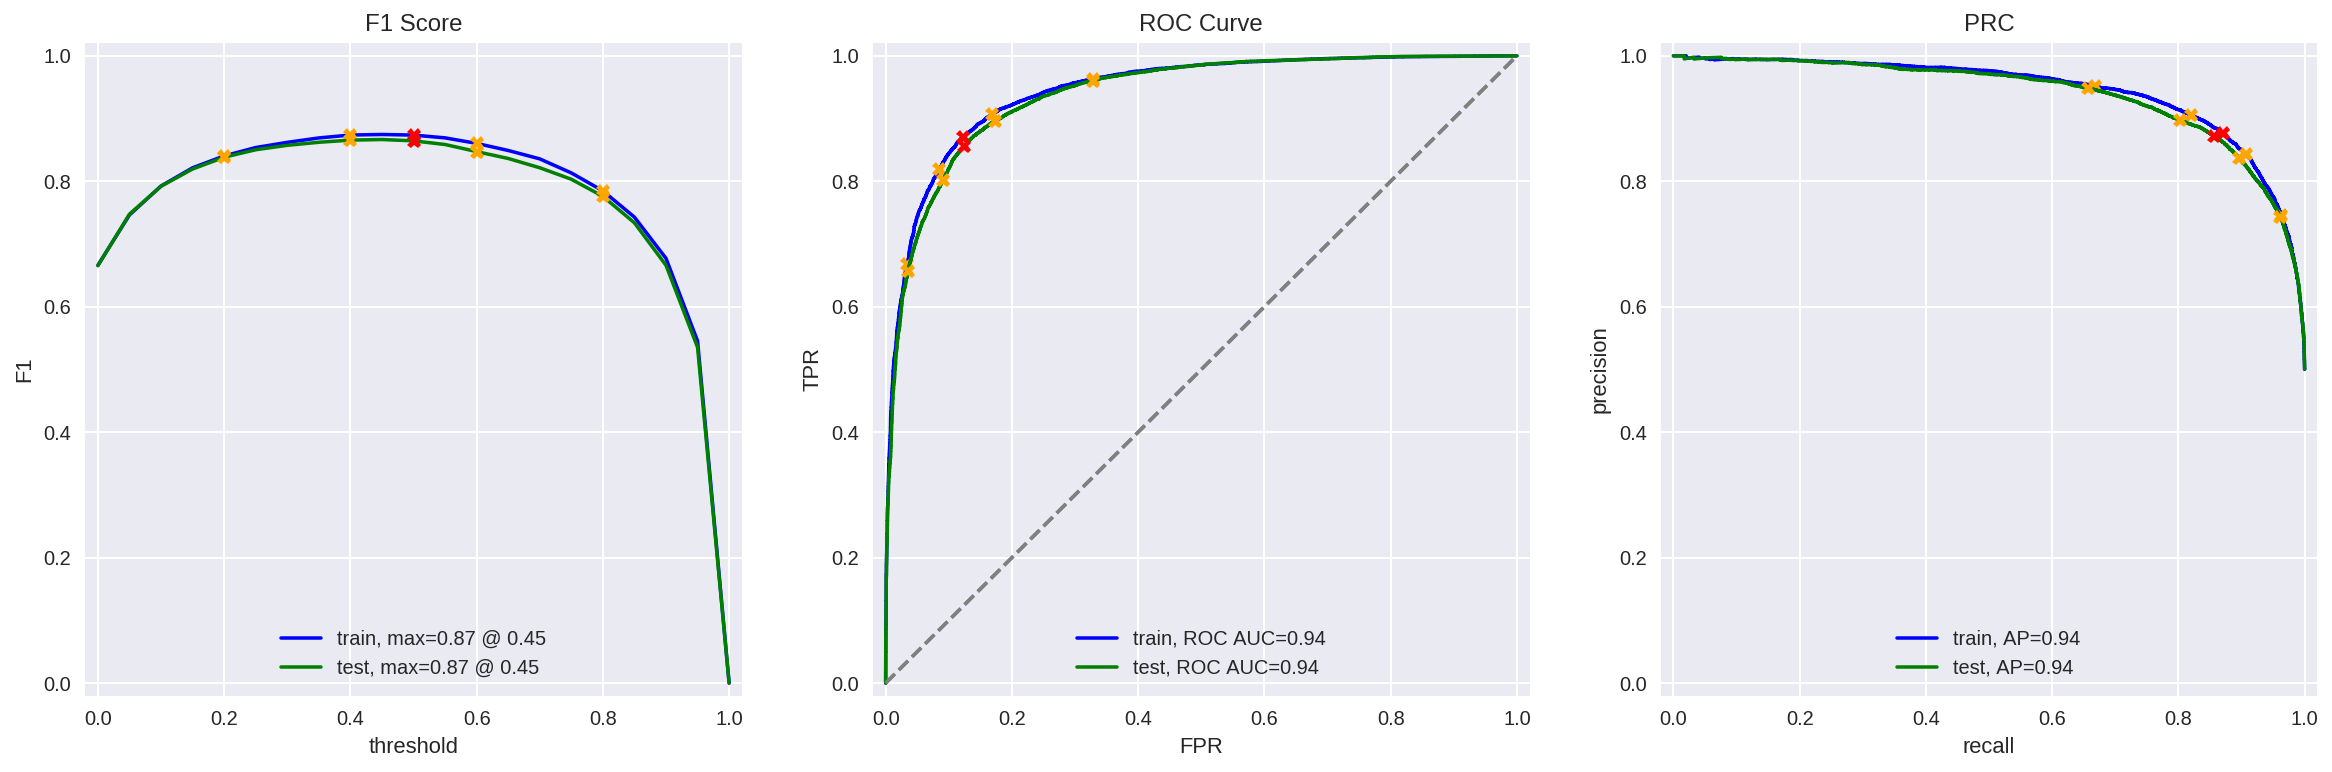

In [70]:
evaluate_model(best_bert_model, train_features_9, train_y, test_features_9, test_y)

In [71]:
model_results_df = pd.DataFrame({'model': ['LogisticRegression-NLTK', 'LogisticRegression-Spacy', 'LGBMClassifier', 
                                          'LogisticRegression-BERT'],
              'best_f1': [best_lr_f1, best_lr_spacy_f1, best_lgbm_f1, best_bert_f1],
              'train_time': [best_lr_time, best_lr_spacy_time, best_lgbm_time, best_bert_time]})

In [72]:
model_results_df

,model,best_f1,train_time
0,LogisticRegression-NLTK,0.880515,123.14
1,LogisticRegression-Spacy,0.878975,115.41
2,LGBMClassifier,0.869776,6286.33
3,LogisticRegression-BERT,0.864442,366.80


1) The DummyClassifier, as expected, produces an F1 score of 50%, which is as good as flipping an unbiased coin.

2) Comparing the LogisticRegression models with NLTK used for preprocessing and Spacy for preprocessing, the model with reviews preprocesed using NLTK, comes out at the top with best f1 score of 88%. Additionally, the preprocessing time was 9x lower than that taken for the Spacy preprocessed reviews. However, during training, the Spacy preprocessed
model finished about 8 seconds earlier.

3) Both the models were trained using 5 fold cross-validation with hyperparameter tuning on the C parameter.

4) The LightGBM model turned out to have a lower f1 score, and it took more than an hour to complete training.

5) The BERT encodings on GPU took about 20 minutes each on both the training and test reviews. The LogisticRegression model built on top of this performed the poorest with an f1 score of 86.4%.

## My Reviews

In [74]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(clean_reviews)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


### Model 2

In [87]:
texts = my_reviews['review_norm'].apply(text_preprocessing_1)

model_2 = best_lr_model

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.17:  i did not simply like it not my kind of movie
0.14:  well i wa bored and felt asleep in the middle of the movie
0.49:  i wa really fascinated with the movie
0.13:  even the actor looked really old and disinterested and they got paid to be in the movie what a soull
0.25:  i did n't expect the reboot to be so good writer really cared about the source material
0.56:  the movie had it upside and downside but i feel like overall it 's a decent flick i could see myself
0.04:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wo 
0.87:  launching on netflix wa a brave move i really appreciate being able to binge on episode after episod


### Model 3

In [93]:
texts = my_reviews['review_norm']

model_3 = best_lr_spacy_model

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.21:  i did not simply like it not my kind of movie 
0.09:  well i was bored and felt asleep in the middle of the movie 
0.50:  i was really fascinated with the movie
0.09:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.19:  i didn't expect the reboot to be so good writers really cared about the source material
0.53:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.92:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 4

In [94]:
texts = my_reviews['review_norm']

model_4 = best_lgbm_model

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.54:  i did not simply like it not my kind of movie 
0.17:  well i was bored and felt asleep in the middle of the movie 
0.60:  i was really fascinated with the movie
0.22:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.24:  i didn't expect the reboot to be so good writers really cared about the source material
0.68:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.11:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.92:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 9

In [101]:
texts = my_reviews['review_norm']

model_9 = best_bert_model

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.27:  i did not simply like it not my kind of movie 
0.01:  well i was bored and felt asleep in the middle of the movie 
0.97:  i was really fascinated with the movie
0.00:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.18:  i didn't expect the reboot to be so good writers really cared about the source material
0.94:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.06:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.94:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


## Conclusions

1) Despite the relatively lower f1 score produced by the BERT embeddings, the predictions on the sample reviews are
of a higher quality compared to the predictions produced by the model with the best f1 score; this seems to suggest that
f1 score is not an appropriate evaluation metric for BERT trained models.

2) The BERT embeddings were obtained using the GPU provided in the Colab platform; 

3) BERT embeddings definitely outperform TFIDF vectors because it captures the semantic representation of the underlying
dataset on which it was trained. Therefore, despite, the relatively higher training time, BERT embeddings